In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score,KFold
from datetime import datetime
from sklearn.metrics import r2_score,mean_squared_error,roc_curve,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.decomposition import PCA
import seaborn 
import xgboost as xgb

In [2]:
df = pd.read_csv('predictionQuery.csv')
df = df.head(20000)
df.head()

,lon,lat,ROUTE_NUMBER,Trip,TripTime,vehicleID,lastStopOrder,lineID,lineType,DELAY,Current_Stop,Current_Stop_ID,Current_Time,Current_Day,Current_Hour,Current_Minutes,Current_Seconds,destination,Dir
0,21.44037,49.06720,707444,126,940,1007803948,10,1007040415,2,-244,"Chmeľov, nám.",881,1614091077437,23,15,37,57,"Prešov, AS",0
1,21.06271,49.09058,708461,24,940,1007804597,21,1007040439,2,-262,Uzovský Šalgov,169,1614091077437,23,15,37,57,"Sabinov, AS",0
2,21.40102,49.15612,701411,48,940,1007802497,3,1007040359,2,-226,"Koprivnica, Jednota",404,1614091107428,23,15,38,27,"Bardejov, AS",0
3,21.45097,48.88978,707403,54,940,1007803118,1,1007040396,2,-203,"Červenica, horný koniec",1073,1614091107428,23,15,38,27,"Prešov, AS",0
4,21.06271,49.09058,708461,24,940,1007804597,21,1007040439,2,-262,Uzovský Šalgov,169,1614091107428,23,15,38,27,"Sabinov, AS",0


In [3]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('ROUTE_NUMBER', 'vehicleID'),
 ('ROUTE_NUMBER', 'lineID'),
 ('TripTime', 'Current_Hour'),
 ('vehicleID', 'lineID'),
 ('lastStopOrder', 'DELAY'),
 ('Current_Time', 'Current_Day')]

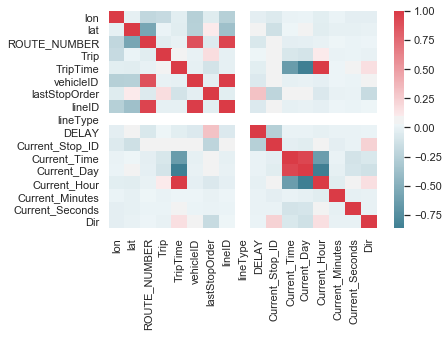

In [4]:
seaborn.set(style='white')
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
seaborn.heatmap(df.corr(),cmap=cmap)

In [5]:
df = df.drop(["destination","Current_Stop","Trip","lineType","lastStopOrder"],axis = 1)
df = df.drop("Current_Time",axis = 1)
df = df.drop(["lineID","vehicleID","TripTime"],axis = 1)
#df = df.drop("lon",axis = 1)
#df = df.drop("lat",axis = 1)

print('Dimension reduced to:')
print(len(df.columns))
df.describe()

Dimension reduced to:
10


,lon,lat,ROUTE_NUMBER,DELAY,Current_Stop_ID,Current_Day,Current_Hour,Current_Minutes,Current_Seconds,Dir
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,21.217007,49.096008,706264.364650,-40.305950,1190.04410,23.740850,10.159550,30.696050,30.303300,0.445850
std,0.173520,0.131109,3023.863381,147.261969,862.45689,0.438179,4.683235,17.062524,17.250634,0.497072
min,20.586320,48.823940,701402.000000,-785.000000,4.00000,23.000000,3.000000,0.000000,0.000000,0.000000
25%,21.089910,48.996030,701429.000000,-113.000000,434.00000,23.000000,6.000000,16.000000,15.000000,0.000000
50%,21.250720,49.093530,707421.000000,-24.000000,935.00000,24.000000,9.000000,32.000000,31.000000,0.000000
75%,21.315853,49.167540,707449.000000,43.000000,2130.00000,24.000000,15.000000,46.000000,45.000000,1.000000
max,21.754350,49.436490,712459.000000,1188.000000,3112.00000,24.000000,23.000000,59.000000,59.000000,1.000000


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer


def LabelEncoding(col):
    encoder = LabelEncoder()
    encoder.fit(df[col])
    list(encoder.classes_)
    return encoder.transform(df[col])

def KBinsDiscretizing(currCol):
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    discretizer.fit(df[currCol])
    return discretizer.transform(df[currCol])

df['lon_Encoded']=LabelEncoding('lon')
df['lat_Encoded']=LabelEncoding('lat')
df['Current_Seconds_Encoded']=LabelEncoding('Current_Seconds')
df['Current_Minutes_Encoded']=LabelEncoding('Current_Minutes')
df['Current_Hour_Encoded']= LabelEncoding('Current_Hour')
df['Current_Day_Encoded']= LabelEncoding('Current_Day')
df['Current_Stop_ID_Encoded'] = LabelEncoding('Current_Stop_ID')
df['RouteNumber_Encoded'] = LabelEncoding('ROUTE_NUMBER')


In [7]:
df.head()

,lon,lat,ROUTE_NUMBER,DELAY,Current_Stop_ID,Current_Day,Current_Hour,Current_Minutes,Current_Seconds,Dir,lon_Encoded,lat_Encoded,Current_Seconds_Encoded,Current_Minutes_Encoded,Current_Hour_Encoded,Current_Day_Encoded,Current_Stop_ID_Encoded,RouteNumber_Encoded
0,21.44037,49.06720,707444,-244,881,23,15,37,57,0,3744,1625,57,37,10,0,407,37
1,21.06271,49.09058,708461,-262,169,23,15,37,57,0,802,1871,57,37,10,0,87,54
2,21.40102,49.15612,701411,-226,404,23,15,38,27,0,3560,2625,27,38,10,0,194,4
3,21.45097,48.88978,707403,-203,1073,23,15,38,27,0,3804,166,27,38,10,0,506,18
4,21.06271,49.09058,708461,-262,169,23,15,38,27,0,802,1871,27,38,10,0,87,54


In [8]:
df = df.drop(['ROUTE_NUMBER','Current_Stop_ID','Current_Hour','Current_Minutes','Current_Seconds','lon','lat',"destination",
              'Current_Day'],axis =1, errors='ignore')

,DELAY,Dir,lon_Encoded,lat_Encoded,Current_Seconds_Encoded,Current_Minutes_Encoded,Current_Hour_Encoded,Current_Day_Encoded,Current_Stop_ID_Encoded,RouteNumber_Encoded
0,-244,0,3744,1625,57,37,10,0,407,37
1,-262,0,802,1871,57,37,10,0,87,54
2,-226,0,3560,2625,27,38,10,0,194,4
3,-203,0,3804,166,27,38,10,0,506,18
4,-262,0,802,1871,27,38,10,0,87,54
5,105,0,3910,3342,42,38,10,0,365,16
6,-203,0,3804,166,42,38,10,0,506,18
7,-184,0,3744,1625,42,38,10,0,407,37
8,-247,0,414,2598,42,38,10,0,649,46
9,-202,0,802,1871,12,39,10,0,87,54


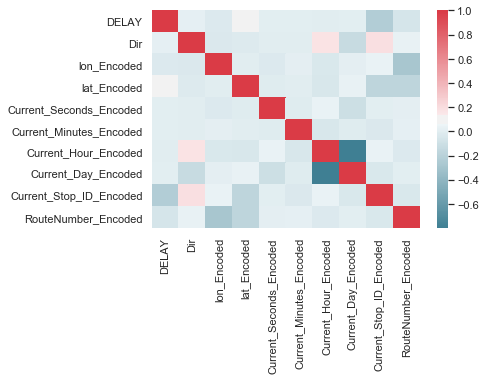

In [9]:
seaborn.heatmap(df.corr(),cmap=cmap)
df.head(10)

In [10]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

In [11]:
train_x, test_x, train_y, test_y = train_test_split(df.drop('DELAY', axis=1), df['DELAY'], test_size=0.3, random_state=1234)

#### GridSearch for Linear Regression

In [167]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True,False]}
grid_search = GridSearchCV(LinearRegression(), param_grid, cv = 5)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
{'copy_X': True, 'fit_intercept': True, 'normalize': False}


<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)>

In [168]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

regressor = LinearRegression(fit_intercept=bestParameters.get('fit_intercept'),
                             normalize=bestParameters.get('normalize'), 
                             copy_X=bestParameters.get('copy_X'))  
regressor.fit(train_x, train_y)
folds = KFold(n_splits = 5, shuffle = True, random_state = 1234)
scores = cross_val_score(regressor, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
#y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred = regressor.predict(test_x)
regressor.score(test_x,test_y)

0.06177944235623665
0.004063130842905392
[0.0678926  0.05948388 0.0632514  0.05568876 0.06258057]


0.06812321612285278

In [169]:
import numpy as np
from sklearn import metrics
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))


Mean Absolute Error (MAE): 102.54169851548062
Mean Squared Error (MSE): 19344.445348445526
Root Mean Squared Error (RMSE): 139.08431021666507
Explained Variance Score: 0.06906680633347462
Max Error: 1181.6077730143475
Median Absolute Error: 77.6138622124931
R^2: 0.06812321612285277


#### SVR Model execution

#### GridsearchCV for SVR

In [170]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 10, 100], 'gamma' : [0.001, 0.01, 0.1, 0.001]}
grid_search = GridSearchCV(SVR(), param_grid, cv = 5)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
{'C': 100, 'gamma': 0.001}


<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)>

#### SVR regressor Model

In [171]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', 
              C=bestParameters.get('C'),
              gamma=bestParameters.get('gamma'), epsilon=1)
svr_rbf.fit(train_x, train_y)
folds = KFold(n_splits = 5, shuffle = True, random_state = 1234)
scores = cross_val_score(svr_rbf, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
#y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)
y_pred_svr = svr_rbf.predict(test_x)
svr_rbf.score(test_x,test_y)

0.4957429670311404
0.01460469562399126
[0.52013856 0.47879022 0.48753503 0.50375055 0.48850047]


0.4992393895077656

In [172]:
import numpy as np
from sklearn import metrics
y_pred= y_pred_svr
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 70.3385671512651
Mean Squared Error (MSE): 10395.082729733836
Root Mean Squared Error (RMSE): 101.95627852042186
Explained Variance Score: 0.49924562003100603
Max Error: 1101.7829191940239
Median Absolute Error: 52.142914458103874
R^2: 0.4992393895077656


#### XGBoost Model

In [173]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.8, 
                          learning_rate = 1,
                          max_depth = 5, alpha = 10, 
                          n_estimators = 100)
xg_reg.fit(train_x,train_y)
folds = KFold(n_splits = 5, shuffle = True, random_state = 1234)
scores= cross_val_score(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
#y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)

preds_y = xg_reg.predict(test_x)
rmse = np.sqrt(mean_squared_error(test_y, preds_y))
print(xg_reg.score(test_x,test_y))

0.7383138797946661
0.016987305824617605
[0.7364734  0.72481764 0.73118245 0.72770716 0.77138875]
0.7182412093169792


In [174]:
import numpy as np
from sklearn import metrics
y_pred= preds_y
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 54.611751015345256
Mean Squared Error (MSE): 5848.914386658174
Root Mean Squared Error (RMSE): 76.47819549818219
Explained Variance Score: 0.7182446533998019
Max Error: 646.2919311523438
Median Absolute Error: 40.709075927734375
R^2: 0.7182412093169792


#### GridSearch for RandomForest

In [175]:
startTimeGS = datetime.now()
param_grid = {'n_estimators': [10,15,20,25,100,500,600,700,800,900,1000]}

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=10)
grid_rf.fit(train_x, train_y)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.score
print('Random forest Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')

Random forest Grid Search with non-redundant variables took [ 0:31:09.625132 ] seconds.


In [176]:
print(bestModel)
print(bestParameters)
gridScores

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
{'n_estimators': 600}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False)

#### RandomForest Model

In [177]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = bestParameters.get('n_estimators'),
                             random_state = 1234)
regr.fit(train_x, train_y)
folds = KFold(n_splits = 5, shuffle = True, random_state = 1234)
scores = cross_val_score(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
#y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_svr = regr.predict(test_x)
regr.score(test_x,test_y)

0.7383138797946661
0.016987305824617605
[0.7364734  0.72481764 0.73118245 0.72770716 0.77138875]


0.8711463826111701

In [178]:
import numpy as np
from sklearn import metrics
y_pred= y_pred_svr
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 32.33293777777778
Mean Squared Error (MSE): 2674.8190347194445
Root Mean Squared Error (RMSE): 51.71865267695442
Explained Variance Score: 0.8714588371061265
Max Error: 466.47
Median Absolute Error: 19.02166666666667
R^2: 0.8711463826111701


#### GridSearch for NN

In [ ]:
from sklearn.neural_network import MLPRegressor
startTimeGS = datetime.now()
param_grid = {'activation':['logistic', 'tanh', 'relu'],
             'solver':['sgd', 'adam']}

grid_rf = GridSearchCV(MLPRegressor(), param_grid, cv=10)
grid_rf.fit(train_x, train_y)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.score
print('MLPRegressor Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')

In [ ]:
print(bestModel)
print(bestParameters)
gridScores

In [ ]:
regr = MLPRegressor(random_state=bestParameters.get('random_state'),
                    max_iter=bestParameters.get('max_iter'),
                    hidden_layer_sizes = bestParameters.get('hidden_layer_sizes'),
                    activation = bestParameters.get('activation'),
                    solver =  bestParameters.get('solver'))
regr.fit(train_x, train_y)
folds = KFold(n_splits = 5, shuffle = True, random_state = 1234)
scores = cross_val_score(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
#y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_svr = regr.predict(test_x)
regr.score(test_x,test_y)